In [1]:
import os
import json
import random

import glob
import matplotlib.pyplot as plt
import numpy as np
from skimage import io, transform
from skimage.filters import gaussian

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
def read_image(im_path, dim):
    image = io.imread(im_path, as_grey=True)
    image = transform.resize(image, dim)
    return image[np.newaxis, :, :, np.newaxis]

In [3]:
def show_landmarks(image, landmarks, title='', ax=None, colour='red', dot_size=70):
    """Show image with landmarks."""
    h, w = image.shape[:2]
    if ax is None: fig, ax = plt.subplots()
    plt.imshow(image, cmap='gray')
    plt.scatter(landmarks[:, 1] * w, landmarks[:, 0] * h, s=dot_size, marker='.', c=colour)
    ax.set_title(title)
    ax.axis('off')
    return ax

In [4]:
def plot_loss(hist,name,plt,RMSE_TF=False):
    '''
    RMSE_TF: if True, then RMSE is plotted with original scale 
    '''
    loss = hist['loss']
    val_loss = hist['val_loss']
    if RMSE_TF:
        loss = np.sqrt(np.array(loss))*48 
        val_loss = np.sqrt(np.array(val_loss))*48 
        
    plt.plot(loss, "--", linewidth=3, label="train:"+name)
    plt.plot(val_loss, linewidth=3, label="val:"+name)

In [5]:
def plot_hist(hists):
    for i, hist in enumerate(hists):
        plot_loss(hist.history, "model 1", plt)
    plt.legend()
    plt.grid()
    plt.yscale("log")
    plt.xlabel("epoch")
    plt.ylabel("log loss")
    plt.show()

# Data

In [6]:
IMAGE_DIR = '../data/train/'

In [7]:
full_img_list = glob.glob(IMAGE_DIR + '*.jpg')
full_img_list = [os.path.basename(p) for p in full_img_list]

In [8]:
with open('../data/train/annotations.json') as json_data:
    data = json.load(json_data)

## Split Into Training/Val

In [9]:
train_ratio = 0.9

In [10]:
keys = list(data.keys())
random.shuffle(keys)
cutoff =int(train_ratio * len(keys))

train_data = {k: data[k] for k in keys[:cutoff] if len(data[k]) == 4}
val_data = {k: data[k] for k in keys[cutoff:] if len(data[k]) == 4}

print(f'Train Samples: {len(train_data)}, Val Samples: {len(val_data)}')

Train Samples: 274, Val Samples: 31


## Generators

### Load Data

In [11]:
from whale_lm_generator import WhaleLMGenerator

Using TensorFlow backend.


In [12]:
H, W = 124, 124
batch_size = 12

In [13]:
train_generator = WhaleLMGenerator(IMAGE_DIR, train_data, 4, dim=(H, W), transforms=['horizontal_flip'], batch_size=batch_size)
val_generator = WhaleLMGenerator(IMAGE_DIR, val_data, 4, dim=(H, W), batch_size=batch_size)

In [14]:
def predict_all(model):
    predictions = {}
    for im_name in full_img_list:
        im = read_image(os.path.join(IMAGE_DIR, im_name), dim=(H, W))
        out = model.predict(im)[0]
        predictions[im_name] = [{'x': float(out[i]), 'y': float(out[i+1])} for i in range(0, len(out), 2)]
    return predictions

# Test Runner

In [15]:
import numpy as np
import matplotlib.pyplot as plt

In [16]:
def run_test(model, run_on_val=True):
    
    if run_on_val:
        batch = val_generator[0]
    else:
        batch = train_generator[0]

    images, gts = batch
    
    batch_out = model.predict(images)

    fig = plt.figure(figsize=(16, 8))
    
    for idx in range(12):
        ax = plt.subplot(3, 4, idx + 1)
        
        sample = images[idx]
        
        gt = gts[idx]
        gt = np.reshape(gt, (4, 2))
        gt = np.flip(gt, axis=1)

        out = batch_out[idx]
        out = np.reshape(out, (4, 2))
        out = np.flip(out, axis=1)

        ax = show_landmarks(sample[:,:,0], gt, ax=ax, colour='yellow', dot_size=80)
        ax = show_landmarks(sample[:,:,0], out, ax=ax)
        

    plt.show()

# Training

In [17]:
from keras.models import Model, Sequential
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPool2D, Dense
from keras.layers import Activation, BatchNormalization, concatenate
from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import ModelCheckpoint, Callback
from keras import applications
import keras.backend as K
import tensorflow as tf

from tensorboard_logger import TensorBoardLogger

# Losses and Metrics

In [18]:
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def jaccard(y_true, y_pred, threshold=0.5, axis=(1, 2, 3), smooth=1e-5): 
        pre = tf.cast(y_pred > threshold, dtype=tf.float32)
        truth = tf.cast(y_true > threshold, dtype=tf.float32)
        inse = tf.reduce_sum(tf.multiply(pre, truth), axis=axis)  # AND
        union = tf.reduce_sum(tf.cast(tf.add(pre, truth) >= 1, dtype=tf.float32), axis=axis)  # OR
        batch_iou = (inse + smooth) / (union + smooth)
        iou = tf.reduce_mean(batch_iou)
        return iou

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def jacckard_loss(y_true, y_pred):
    return 1 - jaccard(y_true, y_pred)

## Single Layer Model

In [ ]:
def create_simple_model(H, W):
    inputs = Input((H, W, 1))
    
    x = Flatten()(inputs)
    x = Dense(100, activation='relu')(x)
    out = Dense(8)(x)
    
    model = Model(inputs=inputs, outputs=out)

    sgd = SGD(lr=0.001, momentum=0.9, nesterov=True)
    model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])
    return model

In [ ]:
model = create_simple_model(H, W)
tensorboard = TensorBoardLogger(log_name='simple')

In [ ]:
fit_args = dict(
    generator=train_generator,
    steps_per_epoch=200,
    callbacks=[tensorboard],
    validation_data=val_generator,
    validation_steps=50,
    workers=6,
    epochs=10,
)

In [ ]:
hist = model.fit_generator(**fit_args)

In [ ]:
plot_hist([hist])

In [ ]:
run_test(model)

## Simple Conv Model

In [15]:
def create_simple_conv_model(H, W, C):
    
    def conv_layer(x, filters, k_size):
        x = Conv2D(filters, (k_size, k_size), activation='relu')(x)
        x = MaxPool2D(pool_size=(2,2))(x)
        return x
    
    image = Input((H, W, C))
    
    x = conv_layer(image, 32, 3)
    x = conv_layer(image, 64, 2)
    x = conv_layer(image, 128, 2)
    
    x = Flatten()(x)
    x = Dense(500, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(500, activation='relu')(x)
    x = Dropout(0.1)(x)
    out = Dense(8)(x)
    
    model = Model(inputs=image, outputs=out)
        
    sgd = SGD(lr=0.01, momentum = 0.9, nesterov=True)
    model.compile(loss="mean_squared_error", optimizer=sgd, metrics=['accuracy'])
    
    return model

In [16]:
model = create_simple_conv_model(H, W, 1)
tensorboard = TensorBoardLogger(log_name='simple-conv')

Instructions for updating:
Use the retry module or similar alternatives.


In [17]:
fit_args = dict(
    generator=train_generator,
    steps_per_epoch=200,
    callbacks=[tensorboard],
    validation_data=val_generator,
    validation_steps=50,
    workers=6,
    epochs=10,
)

In [18]:
hist2 = model.fit_generator(**fit_args)

Epoch 1/10
200/200 [==============================] - 42s 208ms/step - loss: 0.0201 - acc: 0.8692 - val_loss: 0.0071 - val_acc: 0.8117
Epoch 2/10
200/200 [==============================] - 40s 202ms/step - loss: 0.0071 - acc: 0.9054 - val_loss: 0.0062 - val_acc: 0.8617
Epoch 3/10
200/200 [==============================] - 41s 203ms/step - loss: 0.0051 - acc: 0.9138 - val_loss: 0.0053 - val_acc: 0.8400
Epoch 4/10
200/200 [==============================] - 41s 203ms/step - loss: 0.0039 - acc: 0.9171 - val_loss: 0.0052 - val_acc: 0.8300
Epoch 5/10
200/200 [==============================] - 41s 204ms/step - loss: 0.0030 - acc: 0.9258 - val_loss: 0.0046 - val_acc: 0.8483
Epoch 6/10
200/200 [==============================] - 41s 205ms/step - loss: 0.0025 - acc: 0.9267 - val_loss: 0.0047 - val_acc: 0.8617
Epoch 7/10
200/200 [==============================] - 41s 204ms/step - loss: 0.0021 - acc: 0.9304 - val_loss: 0.0044 - val_acc: 0.8400
Epoch 8/10
200/200 [==============================] - 4

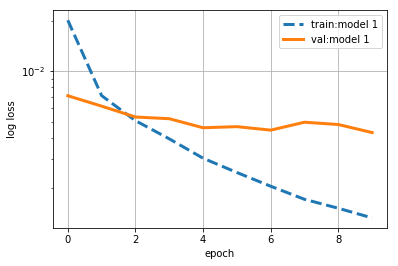

In [19]:
plot_hist([hist2])

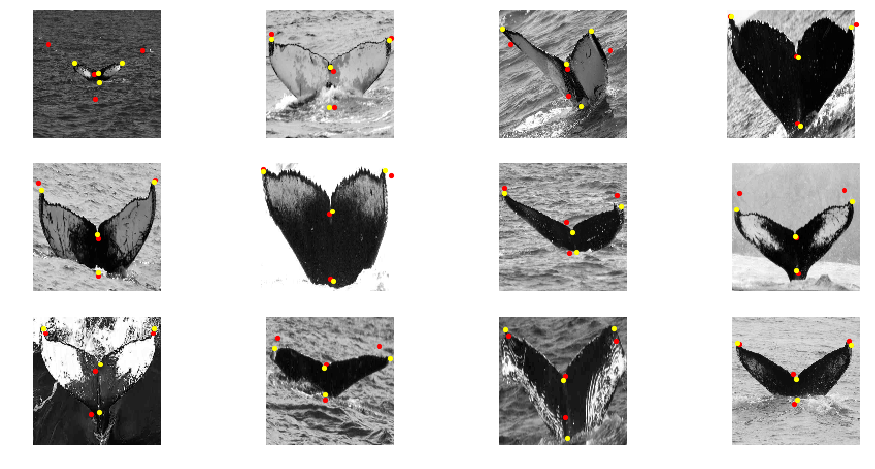

In [20]:
run_test(model)

## Pre-Trained Model

In [19]:
def create_pretrained_model(base='VGG16'):
    
    if base == 'VGG16':
        base = applications.vgg16.VGG16(
                include_top=False, 
                weights=None, 
                pooling=None,
                input_shape=(H, W, 1),)
        for layer in base.layers[:5]:
            layer.trainable = False
    
    x = Flatten()(base.output)
    x = Dense(4096, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(256, activation='relu')(x)

    out = Dense(8, activation='linear')(x)
    
    model = Model(inputs=base.input, outputs=out)
    
    optimizer = Adam(lr=1e-4)
    
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['accuracy'])
    
    return model

In [20]:
# model = create_pretrained_model(base='VGG16')
# model.summary()

In [21]:
# lrs = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
# for lr in lrs:
#     print(f'Learning Rate: {lr}')
#     K.set_value(model.optimizer.lr, lr)
#     model.fit_generator(
#         train_generator,
#         steps_per_epoch=100,
#         workers=6,
#         epochs=1
#     )

In [22]:
model = create_pretrained_model(base='VGG16')
tensorboard = TensorBoardLogger(log_name='VGG16')

Instructions for updating:
Use the retry module or similar alternatives.


In [23]:
model.load_weights('../checkpoints/VGG16')

In [20]:
fit_args = dict(
    generator=train_generator,
    steps_per_epoch=200,
    callbacks=[tensorboard],
    validation_data=val_generator,
    validation_steps=50,
    workers=6,
    epochs=1,
)

In [21]:
K.set_value(model.optimizer.lr, 1e-4)

In [24]:
hist3 = model.fit_generator(**fit_args)

Epoch 1/1
200/200 [==============================] - 36s 182ms/step - loss: 1.3767e-04 - acc: 0.9742 - val_loss: 0.0011 - val_acc: 1.0000


In [ ]:
plot_hist([hist3])

In [26]:
model.save_weights('../checkpoints/VGG16')

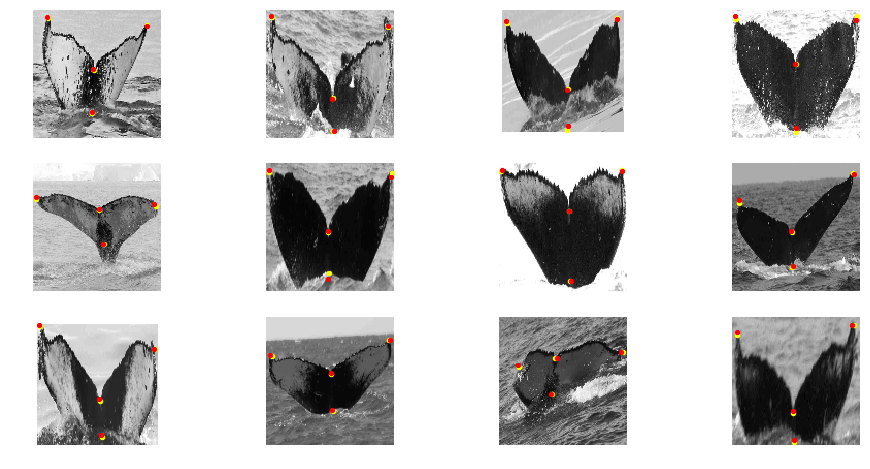

In [24]:
run_test(model)

In [25]:
all_preds = predict_all(model)

In [26]:
len(all_preds)

9850

In [27]:
with open('../data/train/predictions.json', 'w') as fp:
    json.dump(all_preds, fp)

## UNET

In [ ]:
def get_unet(H, W, C):
    def conv_block(in_layer, filters, pooling=True):
        x = Conv2D(filters, (3, 3), activation='relu', padding='same')(in_layer)
        x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        mp = MaxPool2D(pool_size=(2, 2))(x) if pooling else None
        return x, mp
    
    def up_block(in_layer, conv_layer, filters):
        x = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(in_layer)
        x = concatenate([x, conv_layer], axis=3)
        x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        return x
    
    inputs = Input((H, W, C))
    
    c1, mp = conv_block(inputs, 32)
    c2, mp = conv_block(mp, 64)
    c3, mp = conv_block(mp, 128)
    c4, mp = conv_block(mp, 256)
    c5, _ = conv_block(mp, 512, pooling=False)
    
    x = up_block(c5, c4, 256)
    x = up_block(x, c3, 128)
    x = up_block(x, c2, 64)
    x = up_block(x, c1, 32)
    
    out = Conv2D(4, (1, 1), activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=out)
    model.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=[dice_coef, jaccard, 'accuracy'])

    return model

In [ ]:
model = get_unet(H, W, 1)
model.summary()

In [ ]:
lrs = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
for lr in lrs:
    print(f'Learning Rate: {lr}')
    K.set_value(model.optimizer.lr, lr)
    model.fit_generator(
        train_generator,
        steps_per_epoch=100,
        epochs=1
    )

In [ ]:
model = get_unet(H, W, 1)
tensorboard = TensorBoardLogger(log_name='UNET-64')

In [ ]:
model.load_weights('checkpoints/unet-64.h5')

In [ ]:
K.set_value(model.optimizer.lr, 1e-5)

In [ ]:
fit_args = dict(
    generator=train_generator,
    steps_per_epoch=200,
    callbacks=[tensorboard],
#     validation_data=val_generator,
#     validation_steps=100,
    workers=6,
    epochs=10,
)

In [ ]:
model.fit_generator(**fit_args)

In [ ]:
model.save_weights('checkpoints/unet-64.h5')

In [ ]:
run_test(H, W, model)